In [1]:
import uproot as up
import numpy as np
import pandas as pd
import awkward as ak
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Check access to GPU
torch.cuda.is_available()

# Assign the name to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Define vectorized deltaR function
def deltaR(eta1, phi1, eta2, phi2):
    d_eta = eta1 - eta2
    d_phi = (phi1 - phi2 + np.pi) % (2 * np.pi) - np.pi
    return np.sqrt(d_eta**2 + d_phi**2)

# Define function to calculate delta R between two objects
def calculate_deltaR(df, object1_prefix, object2_prefix):
    # Create new column name
    col_name = f'deltaR_{object1_prefix}_{object2_prefix}'
    
    # Select the appropriate columns for eta and phi
    eta1 = df.get(f'{object1_prefix}_eta_NOSYS', df.get(f'{object1_prefix}_eta_fitted_NOSYS', np.nan))
    phi1 = df.get(f'{object1_prefix}_phi_NOSYS', df.get(f'{object1_prefix}_phi_fitted_NOSYS', np.nan))
    eta2 = df.get(f'{object2_prefix}_eta_NOSYS', df.get(f'{object2_prefix}_eta_fitted_NOSYS', np.nan))
    phi2 = df.get(f'{object2_prefix}_phi_NOSYS', df.get(f'{object2_prefix}_phi_fitted_NOSYS', np.nan))
    
    # Handle invalid entries (set delta R to NaN for invalid inputs)
    mask = (eta1 == -999) | (eta2 == -999) | (phi1 == -999) | (phi2 == -999)
    delta_r = deltaR(eta1, phi1, eta2, phi2)
    delta_r[mask] = np.nan
    
    # Assign the computed delta R to the new column
    df[col_name] = delta_r

# Define combinations for sig_df and ttbar_df: 78 total
combinations = [
    ('A', 'Hp'), ('A', 'top'), ('A', 'WfromTop'), ('A', 'WfromH'), ('A', 'Wb_nonTop'),
    ('Hp', 'top'), ('Hp', 'WfromTop'), ('Hp', 'WfromH'), ('Hp', 'Wb_nonTop'),
    ('top', 'WfromTop'), ('top', 'WfromH'), ('top', 'Wb_nonTop'),
    ('WfromTop', 'WfromH'), ('WfromTop', 'Wb_nonTop'),
    ('WfromH', 'Wb_nonTop'),
    ('bjet1', 'bjet2'), ('ljet1', 'ljet2'), ('bjet1', 'ljet1'), ('bjet1', 'ljet2'),
    ('bjet2', 'ljet1'), ('bjet2', 'ljet2'), ('bjet1', 'ljet3'), ('bjet1', 'ljet4'),
    ('bjet2', 'ljet3'), ('bjet2', 'ljet4'), ('ljet1', 'ljet3'), ('ljet1', 'ljet4'),
    ('ljet2', 'ljet3'), ('ljet2', 'ljet4'), ('ljet3', 'ljet4'),
    ('bjet1', 'lepton'), ('bjet2', 'lepton'), ('ljet1', 'lepton'),
    ('ljet2', 'lepton'), ('ljet3', 'lepton'), ('ljet4', 'lepton'),
    ('A', 'bjet1'), ('A', 'bjet2'), ('A', 'ljet1'), ('A', 'ljet2'),
    ('A', 'ljet3'), ('A', 'ljet4'), ('A', 'lepton'),
    ('top', 'bjet1'), ('top', 'bjet2'), ('top', 'ljet1'), ('top', 'ljet2'),
    ('top', 'ljet3'), ('top', 'ljet4'), ('top', 'lepton'),
    ('WfromTop', 'bjet1'), ('WfromTop', 'bjet2'), ('WfromTop', 'ljet1'), ('WfromTop', 'ljet2'),
    ('WfromTop', 'ljet3'), ('WfromTop', 'ljet4'),('WfromTop', 'lepton'), 
    ('Wb_nonTop', 'bjet1'), ('Wb_nonTop', 'bjet2'), ('Wb_nonTop', 'ljet1'), ('Wb_nonTop', 'ljet2'),
    ('Wb_nonTop', 'ljet3'), ('Wb_nonTop', 'ljet4'), ('Wb_nonTop', 'lepton'),
    ('Hp', 'bjet1'), ('Hp', 'bjet2'), ('Hp', 'ljet1'), ('Hp', 'ljet2'),
    ('Hp', 'ljet3'), ('Hp', 'ljet4'), ('Hp', 'lepton'),
    ('WfromH', 'bjet1'), ('WfromH', 'bjet2'), ('WfromH', 'ljet1'), ('WfromH', 'ljet2'),
    ('WfromH', 'ljet3'), ('WfromH', 'ljet4'), ('WfromH', 'lepton'),
]

In [5]:
# Define the DNN Model
class Model(nn.Module):
    
    # Build the model architecture
    def __init__(self, in_features=20, h1=32, h2=32, out_features=1, dropout_rate=0.2):
        super().__init__() # Instantiate our nn.Module
        self.fc1 = nn.Linear(in_features, h1) 
        self.norm1 = nn.LayerNorm(h1)
        self.fc2 = nn.Linear(h1, h2)
        self.norm2 = nn.LayerNorm(h2)
        self.out = nn.Linear(h2,out_features)
        
        self.dropout = nn.Dropout(dropout_rate)
    
    # Build forward function
    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x))) # Rectified Linear Unit: If x <= 0: x = 0
        x = self.dropout(x)
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.out(x)

        return torch.sigmoid(x)

In [6]:
# Load the model
model = Model()
model.load_state_dict(torch.load("dnn_model_low_classification.pth"))
model.to(device)

Model(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [7]:
# Top 20 Features we used to train
features = ['Hp_pt_fitted_NOSYS',
    'deltaR_top_ljet2',
    'ljet2_pt_NOSYS',
    'bjet2_pt_NOSYS',
    'cos_theta_star_lep_Wlep_NOSYS',
    'top_pt_fitted_NOSYS',
    'deltaR_Hp_WfromH',
    'A_pt_fitted_NOSYS',
    'deltaR_ljet1_lepton',
    'deltaR_top_Wb_nonTop',
    'ljet2_mass_NOSYS',
    'ljet1_mass_NOSYS',
    'bjet1_mass_NOSYS',
    'MET_NOSYS',
    'deltaR_Hp_Wb_nonTop',
    'Wb_nonTop_mass_fitted_NOSYS',
    'ljet1_pt_NOSYS',
    'A_mass_fitted_NOSYS',
    'deltaR_bjet1_bjet2',
    'Hp_mass_fitted_NOSYS']

In [8]:
# All the branches we will save to our ROOT files
keys = ["Hp_pt_fitted_NOSYS",
    "deltaR_top_ljet2",
    "ljet2_pt_NOSYS",
    "bjet2_pt_NOSYS",
    "cos_theta_star_lep_Wlep_NOSYS",
    "top_pt_fitted_NOSYS",
    "deltaR_Hp_WfromH",
    "A_pt_fitted_NOSYS",
    "deltaR_ljet1_lepton",
    "deltaR_top_Wb_nonTop",
    "ljet2_mass_NOSYS",
    "ljet1_mass_NOSYS",
    "bjet1_mass_NOSYS",
    "MET_NOSYS",
    "deltaR_Hp_Wb_nonTop",
    "Wb_nonTop_mass_fitted_NOSYS",
    "ljet1_pt_NOSYS",
    "A_mass_fitted_NOSYS",
    "deltaR_bjet1_bjet2",
    "Hp_mass_fitted_NOSYS",
    # extra
    "weight_mc_NOSYS",
    "weight_jvt_effSF_NOSYS",
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS",
    "bjet1_pt_NOSYS",
    "WfromTop_pt_fitted_NOSYS",
    "WfromH_pt_fitted_NOSYS"]

1. Signal Mass Test Set
   * Load data and perform preselection cuts
   * Use the DNN model to produce predictions (dnn score)
   * Save top 20 variables, including extra variables and dnn score to a ROOT File for TRExFitter

In [25]:
# Load the eval ROOT file

#400_200_mc20e.root
#400_250_mc20e.root
#400_300_mc20e.root

name = "400_300_mc20a"
file_path = "/data/dajiang/2HDM/ML/samples/signal/Low/{}.root".format(name)
tree = up.open(file_path)["reco"]
arrays = tree.arrays(library = "np")
temp_df = pd.DataFrame(arrays)
sig_df = temp_df[(temp_df['nBjets_NOSYS'] > 1) & (temp_df['nBjets_NOSYS'] + temp_df['nLjets_NOSYS'] > 3)] # preselection cuts

In [26]:
# Calculate delta Rs
for comb in tqdm(combinations):
    calculate_deltaR(sig_df, comb[0], comb[1])

100%|██████████| 78/78 [00:00<00:00, 463.39it/s]


In [27]:
# Process test data
pipeline = joblib.load('preprocessing_pipeline_low.pkl')

sig_df_features = sig_df[features].copy()
sig_df_features.replace(-999, np.nan, inplace=True)

# Scale the test data the same way as the training
sig_df_scaled = pipeline.transform(sig_df_features)
sig_X_scaled = np.array(sig_df_scaled)
sig_X = torch.tensor(sig_X_scaled)
sig_X = sig_X.to(device)

In [28]:
sig_X.shape

torch.Size([4688, 20])

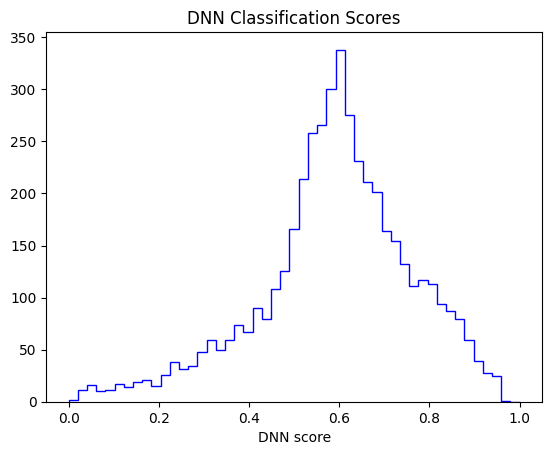

In [29]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients during evaluation
    # Forward pass to generate predictions
    sig_y_pred_test = model(sig_X)

sig_dnn_score = np.concatenate(sig_y_pred_test.cpu().numpy())

# Plot
bin_list = np.linspace(0,1,50)
fig, ax = plt.subplots()
ax.hist(sig_dnn_score,bins=bin_list,histtype="step",color="blue")
ax.set_xlabel("DNN score")
ax.set_title("DNN Classification Scores")
fig.show()

In [30]:
sig_df

,el_pt_NOSYS,el_eta,el_phi,el_charge,el_reco_effSF_tight_NOSYS,el_id_effSF_tight_NOSYS,el_isol_effSF_tight_NOSYS,el_IFFClass,el_select_or_NOSYS,el_select_tight_NOSYS,...,deltaR_Hp_ljet3,deltaR_Hp_ljet4,deltaR_Hp_lepton,deltaR_WfromH_bjet1,deltaR_WfromH_bjet2,deltaR_WfromH_ljet1,deltaR_WfromH_ljet2,deltaR_WfromH_ljet3,deltaR_WfromH_ljet4,deltaR_WfromH_lepton
1,[],[],[],[],[],[],[],[],[],[],...,7.056722,NaN,2.180084,0.799062,1.578272,1.213576,2.010613,5.556988,NaN,1.480465
12,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,2.749841,2.943353,2.907020,1.879968,1.169433,NaN,NaN,3.042668
13,[],[],[],[],[],[],[],[],[],[],...,2.007079,NaN,3.060983,2.639456,2.102295,0.266597,3.164253,1.194457,NaN,0.479418
22,[67624.04],[-0.11005598],[2.5443432],[1.0],[0.99865836],[1.0462617],[1.0],[2],[1],[1],...,0.415396,1.117191,1.535041,0.825613,2.262022,1.493137,2.393500,2.791599,1.307896,2.419712
27,[58583.594],[-0.27643692],[-1.930549],[1.0],[0.9987334],[1.0543293],[1.0],[2],[1],[1],...,2.426533,1.290870,0.804539,4.248404,3.421944,5.316905,3.080619,2.551364,3.805185,3.459200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19037,[34397.71],[1.0131158],[2.503734],[1.0],[1.0002744],[1.0344527],[1.0],[2],[1],[1],...,NaN,NaN,3.408984,3.174700,2.008533,1.027495,2.715890,NaN,NaN,1.423216
19042,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,0.606231,2.803341,1.610734,1.875353,2.935329,NaN,NaN,3.098034
19044,[99981.766],[0.18649605],[-0.104175866],[1.0],[0.99963707],[1.0509322],[1.0],[2],[1],[1],...,1.316587,1.019787,1.573336,1.821261,2.175888,4.631155,0.750037,1.175091,1.552267,0.354466
19045,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,5.262284,3.344050,1.589505,2.218228,1.013599,NaN,NaN,1.822725


In [31]:
for key in keys:
    globals()[key] = sig_df[key].to_numpy()

In [32]:
# Save signal_predictions and background_predictions to a ROOT file

dict_type = {
    # top 20
    "Hp_pt_fitted_NOSYS": "float32",
    "deltaR_top_ljet2": "float32",
    "ljet2_pt_NOSYS": "float32",
    "bjet2_pt_NOSYS": "float32",
    "cos_theta_star_lep_Wlep_NOSYS": "float32",
    "top_pt_fitted_NOSYS": "float32",
    "deltaR_Hp_WfromH": "float32",
    "A_pt_fitted_NOSYS": "float32",
    "deltaR_ljet1_lepton": "float32",
    "deltaR_top_Wb_nonTop": "float32",
    "ljet2_mass_NOSYS": "float32",
    "ljet1_mass_NOSYS": "float32",
    "bjet1_mass_NOSYS": "float32",
    "MET_NOSYS": "float32",
    "deltaR_Hp_Wb_nonTop": "float32",
    "Wb_nonTop_mass_fitted_NOSYS": "float32",
    "ljet1_pt_NOSYS": "float32",
    "A_mass_fitted_NOSYS": "float32",
    "deltaR_bjet1_bjet2": "float32",
    "Hp_mass_fitted_NOSYS": "float32",
    # extra
    "weight_mc_NOSYS": "float32",
    "weight_jvt_effSF_NOSYS": "float32",
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS": "float32",
    "bjet1_pt_NOSYS": "float32",
    "WfromTop_pt_fitted_NOSYS": "float32",
    "WfromH_pt_fitted_NOSYS": "float32",
    "dnn_score": "float32"
    }

dict_val = {
    # top 20
    "Hp_pt_fitted_NOSYS": Hp_pt_fitted_NOSYS,
    "deltaR_top_ljet2": deltaR_top_ljet2,
    "ljet2_pt_NOSYS": ljet2_pt_NOSYS, 
    "bjet2_pt_NOSYS": bjet2_pt_NOSYS,
    "cos_theta_star_lep_Wlep_NOSYS": cos_theta_star_lep_Wlep_NOSYS,
    "top_pt_fitted_NOSYS": top_pt_fitted_NOSYS,
    "deltaR_Hp_WfromH": deltaR_Hp_WfromH,
    "A_pt_fitted_NOSYS": A_pt_fitted_NOSYS,
    "deltaR_ljet1_lepton": deltaR_ljet1_lepton,
    "deltaR_top_Wb_nonTop": deltaR_top_Wb_nonTop,
    "ljet2_mass_NOSYS": ljet2_mass_NOSYS,
    "ljet1_mass_NOSYS": ljet1_mass_NOSYS,
    "bjet1_mass_NOSYS": bjet1_mass_NOSYS,
    "MET_NOSYS": MET_NOSYS,
    "deltaR_Hp_Wb_nonTop": deltaR_Hp_Wb_nonTop,
    "Wb_nonTop_mass_fitted_NOSYS": Wb_nonTop_mass_fitted_NOSYS,
    "ljet1_pt_NOSYS": ljet1_pt_NOSYS,
    "A_mass_fitted_NOSYS": A_mass_fitted_NOSYS,
    "deltaR_bjet1_bjet2": deltaR_bjet1_bjet2,
    "Hp_mass_fitted_NOSYS": Hp_mass_fitted_NOSYS,
    # extra
    "weight_mc_NOSYS": weight_mc_NOSYS,
    "weight_jvt_effSF_NOSYS": weight_jvt_effSF_NOSYS,
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS": weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS,
    "bjet1_pt_NOSYS": bjet1_pt_NOSYS,
    "WfromTop_pt_fitted_NOSYS": WfromTop_pt_fitted_NOSYS,
    "WfromH_pt_fitted_NOSYS": WfromH_pt_fitted_NOSYS,
    "dnn_score": sig_dnn_score
    }

with up.recreate("root_files/{}_eval.root".format(name)) as f:
    tree = f.mktree("reco", dict_type)
    tree.extend(dict_val)

2. Same process, now for background (ttbar)

In [36]:
# Load the eval ROOT file
name = "user.rjoshi.38019065._000004.output"
file_path = "/data/dajiang/2HDM/ML/samples/ttbar/validation/{}.root".format(name) # ttbar
tree = up.open(file_path)["reco"]
arrays = tree.arrays(library = "np")
temp_df = pd.DataFrame(arrays)
tt_df = temp_df[(temp_df['nBjets_NOSYS'] > 1) & (temp_df['nBjets_NOSYS'] + temp_df['nLjets_NOSYS'] > 3)] # preselection cuts

In [37]:
# Calculate delta Rs
for comb in tqdm(combinations):
    calculate_deltaR(tt_df, comb[0], comb[1])

100%|██████████| 78/78 [00:00<00:00, 346.36it/s]


In [38]:
# Process test data
pipeline = joblib.load('preprocessing_pipeline_low.pkl')

tt_df_features = tt_df[features].copy()
tt_df_features.replace(-999, np.nan, inplace=True)

# Scale the test data the same way as the training
tt_df_scaled = pipeline.transform(tt_df_features)
tt_X_scaled = np.array(tt_df_scaled)
tt_X = torch.tensor(tt_X_scaled)
tt_X = tt_X.to(device)

In [39]:
tt_X.shape

torch.Size([37669, 20])

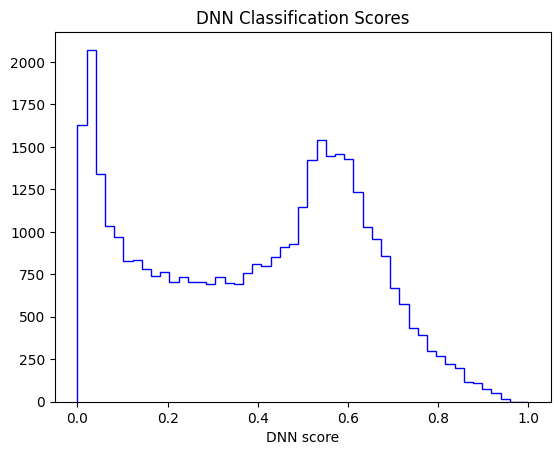

In [40]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients during evaluation
    # Forward pass to generate predictions
    tt_y_pred_test = model(tt_X)

tt_dnn_score = np.concatenate(tt_y_pred_test.cpu().numpy())

# Plot
bin_list = np.linspace(0,1,50)
fig, ax = plt.subplots()
ax.hist(tt_dnn_score,bins=bin_list,histtype="step",color="blue")
ax.set_xlabel("DNN score")
ax.set_title("DNN Classification Scores")
fig.show()

In [41]:
tt_df

,el_pt_NOSYS,el_eta,el_phi,el_charge,el_reco_effSF_tight_NOSYS,el_id_effSF_tight_NOSYS,el_isol_effSF_tight_NOSYS,el_IFFClass,el_select_or_NOSYS,el_select_tight_NOSYS,...,deltaR_Hp_ljet3,deltaR_Hp_ljet4,deltaR_Hp_lepton,deltaR_WfromH_bjet1,deltaR_WfromH_bjet2,deltaR_WfromH_ljet1,deltaR_WfromH_ljet2,deltaR_WfromH_ljet3,deltaR_WfromH_ljet4,deltaR_WfromH_lepton
1,[],[],[],[],[],[],[],[],[],[],...,0.507288,3.556000,1.782669,0.517917,1.212872,3.136815,2.570711,2.572966,1.063746,1.293148
4,[],[],[],[],[],[],[],[],[],[],...,4.212738,0.715081,2.591641,3.625315,3.025835,6.832623,2.068892,4.941395,2.908829,4.181564
10,[],[],[],[],[],[],[],[],[],[],...,3.447240,NaN,2.425100,2.230915,3.292263,1.812729,0.343206,0.407815,NaN,2.143577
13,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,1.716735,3.101434,2.263205,0.007662,2.900718,NaN,NaN,1.359799
28,[],[],[],[],[],[],[],[],[],[],...,3.703408,2.424925,1.102595,1.495461,2.681855,0.181109,0.283962,1.959849,2.911194,2.325183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194218,[],[],[],[],[],[],[],[],[],[],...,2.612198,4.989711,0.775466,2.990035,2.909716,0.862254,3.862747,0.683746,3.808966,3.118282
194219,[45161.96],[-1.4519389],[-3.0709736],[-1.0],[0.99646467],[0.9061966],[1.0011138],[2],[1],[1],...,1.568041,NaN,1.428502,1.836738,2.565689,2.719784,3.542333,2.329844,NaN,2.104017
194228,[30796.9],[0.1082891],[-2.657593],[-1.0],[1.0058374],[0.9606626],[1.0035318],[2],[1],[1],...,5.610221,6.408446,5.022960,1.855743,4.284673,2.373040,4.366379,1.388914,1.096949,2.644035
194229,[],[],[],[],[],[],[],[],[],[],...,NaN,NaN,3.124759,2.533871,2.941439,1.512998,2.702903,NaN,NaN,0.382507


In [42]:
for key in keys:
    globals()[key] = tt_df[key].to_numpy()

In [43]:
# Save signal_predictions and background_predictions to a ROOT file

dict_type = {
    # top 20
    "Hp_pt_fitted_NOSYS": "float32",
    "deltaR_top_ljet2": "float32",
    "ljet2_pt_NOSYS": "float32",
    "bjet2_pt_NOSYS": "float32",
    "cos_theta_star_lep_Wlep_NOSYS": "float32",
    "top_pt_fitted_NOSYS": "float32",
    "deltaR_Hp_WfromH": "float32",
    "A_pt_fitted_NOSYS": "float32",
    "deltaR_ljet1_lepton": "float32",
    "deltaR_top_Wb_nonTop": "float32",
    "ljet2_mass_NOSYS": "float32",
    "ljet1_mass_NOSYS": "float32",
    "bjet1_mass_NOSYS": "float32",
    "MET_NOSYS": "float32",
    "deltaR_Hp_Wb_nonTop": "float32",
    "Wb_nonTop_mass_fitted_NOSYS": "float32",
    "ljet1_pt_NOSYS": "float32",
    "A_mass_fitted_NOSYS": "float32",
    "deltaR_bjet1_bjet2": "float32",
    "Hp_mass_fitted_NOSYS": "float32",
    # extra
    "weight_mc_NOSYS": "float32",
    "weight_jvt_effSF_NOSYS": "float32",
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS": "float32",
    "bjet1_pt_NOSYS": "float32",
    "WfromTop_pt_fitted_NOSYS": "float32",
    "WfromH_pt_fitted_NOSYS": "float32",
    "dnn_score": "float32"
    }

dict_val = {
    # top 20
    "Hp_pt_fitted_NOSYS": Hp_pt_fitted_NOSYS,
    "deltaR_top_ljet2": deltaR_top_ljet2,
    "ljet2_pt_NOSYS": ljet2_pt_NOSYS, 
    "bjet2_pt_NOSYS": bjet2_pt_NOSYS,
    "cos_theta_star_lep_Wlep_NOSYS": cos_theta_star_lep_Wlep_NOSYS,
    "top_pt_fitted_NOSYS": top_pt_fitted_NOSYS,
    "deltaR_Hp_WfromH": deltaR_Hp_WfromH,
    "A_pt_fitted_NOSYS": A_pt_fitted_NOSYS,
    "deltaR_ljet1_lepton": deltaR_ljet1_lepton,
    "deltaR_top_Wb_nonTop": deltaR_top_Wb_nonTop,
    "ljet2_mass_NOSYS": ljet2_mass_NOSYS,
    "ljet1_mass_NOSYS": ljet1_mass_NOSYS,
    "bjet1_mass_NOSYS": bjet1_mass_NOSYS,
    "MET_NOSYS": MET_NOSYS,
    "deltaR_Hp_Wb_nonTop": deltaR_Hp_Wb_nonTop,
    "Wb_nonTop_mass_fitted_NOSYS": Wb_nonTop_mass_fitted_NOSYS,
    "ljet1_pt_NOSYS": ljet1_pt_NOSYS,
    "A_mass_fitted_NOSYS": A_mass_fitted_NOSYS,
    "deltaR_bjet1_bjet2": deltaR_bjet1_bjet2,
    "Hp_mass_fitted_NOSYS": Hp_mass_fitted_NOSYS,
    # extra
    "weight_mc_NOSYS": weight_mc_NOSYS,
    "weight_jvt_effSF_NOSYS": weight_jvt_effSF_NOSYS,
    "weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS": weight_btagSF_DL1dv01_FixedCutBEff_85_NOSYS,
    "bjet1_pt_NOSYS": bjet1_pt_NOSYS,
    "WfromTop_pt_fitted_NOSYS": WfromTop_pt_fitted_NOSYS,
    "WfromH_pt_fitted_NOSYS": WfromH_pt_fitted_NOSYS,
    "dnn_score": tt_dnn_score
    }

with up.recreate("root_files/ttbar_low_eval.root") as f:
    tree = f.mktree("reco", dict_type)
    tree.extend(dict_val)